# MRI-3T-taskfMRI

**Overview**

This tutorial will differ from the others, in that it can't be run using only checkpoint data but rather requires the original datasets. This is because different subjects have a different number of volumes (or TRs) depending on how long it took them to complete the tasks. Each subject will also have an events.tsv file indicating trial onset times and responses. Thus, this tutorial cannot easily be run online, but we include it here as an illustrative example nonetheless.

section 1) will deal with the Mneumonic Similarity Task (MST). This will involve 1.1) A full walkthrough of one subject analysis, and then looping over subjects, 1.2) Plotting group-level data and significance testing, 1.3) Applying the same to the neocortex instead of hippocampus, and 1.4) Contextualizing resulting hippocampal maps by direct spatial correlation to other HippoMaps features

We will then apply the same steps to 2) an item-pairing task retrieval phase and 3) the same task encoding phase

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import pandas as pd
import nilearn
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels
import pickle
from scipy.stats import ttest_1samp
import warnings
warnings.filterwarnings("ignore")
import time
start_time = time.time()

In [112]:
# config

useCheckpoints = True # this will download and use checkpoint numpy array data instead of mapping local data to hippocampal surfaces 
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['MRI-3T-taskfMRI.npz', 'MRI-3T-taskfMRI.pickle'])
    
# locate input data
ses = '01'
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
micapipe_raw = '/data/mica3/BIDS_MICs/rawdata/' # this we need for the events.tsv files
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'

# define which subjects and surfaces to examine
subs = [
 'HC001', 'HC002', 'HC005', 'HC006', 'HC007', 'HC011', 'HC012', 'HC013', 'HC014', 'HC015',
 'HC016', 'HC017', 'HC018', 'HC019', 'HC020', 'HC021', 'HC022', 'HC023', 'HC025', 'HC026',
 'HC027', 'HC028', 'HC029', 'HC030', 'HC031', 'HC032', 'HC033', 'HC034', 'HC035', 'HC036', 
 'HC037', 'HC038', 'HC039', 'HC040', 'HC041', 'HC042', 'HC043', 'HC044', 'HC045', 'HC046', 
 'HC047', 'HC048', 'HC049', 'HC050', 'HC051', 'HC052', 'HC053', 'HC054', 'HC055', 'HC056', 
 'HC057', 'HC058', 'HC059', 'HC060', 'HC061', 'HC063', 'HC065', 'HC067', 'HC068', 'HC069', 
 'HC070', 'HC071', 'HC072', 'HC074', 'HC075', 'HC077', 'HC078', 'HC081', 'HC082', 'HC084', 
 'HC086', 'HC087', 'HC088', 'HC089', 'HC090', 'HC093', 'HC097', 'HC100', 'HC024', 'HC064', 
 'HC073', 'HC101']
hemis = ['L','R']
labels = ['hipp']# ,'dentate'] 
den='2mm'
sigma = 1 # Gaussian smoothing kernal sigma (mm) to apply to surface data
TR = 0.6 # repetition time (seconds)
tasks= ['MST2', 'encoding','retrieval']
slice_time_ref = 0.0
nVolumes=850 # Max timeseries length (will be padded with NaNs if the run is shorter)
tmp_dir = 'tmp_fMRI_3T'

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# 3. Load neocortical surfaces for visualzation
parcL, parcR = load_parcellation('schaefer')
parc = np.concatenate((parcL, parcR))
nP = len(np.unique(parcL))-1 # number of neocortical parcels (one hemisphere)
c69_inf_lh, c69_inf_rh = load_conte69()

## 0) Map data to hippocampal surface

In this example, we loop through subjects and hemispheres, and sample volumetric timeseries data onto hippocampal surfaces. We then apply smoothing. Finally, we save the data from all surfaces into `.func.gii` files.

NOTE: here we save surface fMRI data into a `surf/task-fMRI/` directory within our hippunfold directory. Depending on your lab organization, it may be best to never write project-specific outputs into a shared processed dataset, so consider writing to your own directory instead!

In [113]:
if not useCheckpoints:
    !mkdir -p {tmp_dir}

    cdata_hipp = np.ones((nV,len(hemis),nVolumes,len(tasks),len(subs)))*np.nan
    neo_ts = np.ones((nP,len(hemis),nVolumes,len(tasks),len(subs)))*np.nan
    all_events = []
    all_motion_reg = []

    for s,sub in enumerate(subs):
        sub_events = []
        sub_motion_reg = []

        for t,task in enumerate(tasks):

            # convert affines 
            cmd1a = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-{task}_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
            !{cmd1a}
            cmd1b = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
                f'-inv '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
            !{cmd1b}
            
            for h,hemi in enumerate(hemis):
                for l,label in enumerate(labels):
                    #apply affines
                    cmd2a = f'wb_command -surface-apply-affine '\
                        f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'
                    !{cmd2a}
                    cmd2b = f'wb_command -surface-apply-affine '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                    !{cmd2b}
                    # apply warp (Note this is actually the INVERSE warp)
                    cmd3 = f'wb_command -surface-apply-warpfield '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                    !{cmd3}

                    # sample
                    cmd4 = f'wb_command -volume-to-surface-mapping '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                        f'-enclosing'
                    !{cmd4}

                    # smooth
                    cmd5 = f'wb_command -metric-smoothing '\
                        f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                        f'{sigma} '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
                    !{cmd5}

                    # load mapped hippocmapal surface data
                    func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
                    for k in range(len(func.darrays)):
                        cdata_hipp[iV[l],h,k,t,s] = func.darrays[k].data

                    # Load the neocortical timeseries in fsLR32k and dowmsample to schaefer 400 space
                    func = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
                    func_parc = np.ones((int(nP*2),nVolumes))*np.nan
                    for i in range(int(nP*2)):
                        for k in range(func.shape[0]):
                            func_parc[i,k] = np.nanmean(func[k, parc == (i + 1)])
                    neo_ts[:,:,:,t,s] = func_parc.reshape((nP,2,nVolumes))

            # events and regressors
            sub_events.append(pd.read_table(f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_events.tsv'))
            sub_motion_reg.append(np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D'))
        all_events.append(sub_events)
        all_motion_reg.append(sub_motion_reg)

    np.savez_compressed("checkpoints/MRI-3T-taskfMRI",cdata_hipp, neo_ts)
    with open("checkpoints/MRI-3T-taskfMRI.pickle","wb") as fn:
        pickle.dump(all_events,fn)
        pickle.dump(all_motion_reg,fn)
    !rm -r {tmp_dir}

## 1) Mnemonic Similarity Task (Pattern Separation)

## 1.1) GLM fit 

First we will walk through how this can be done for one subject, and then we will loop through all subjects


In [114]:
cdata_hipp = np.load("checkpoints/MRI-3T-taskfMRI.npz")['arr_0']
neo_ts = np.load("checkpoints/MRI-3T-taskfMRI.npz")['arr_1']
with open("checkpoints/MRI-3T-taskfMRI.pickle","rb") as fn:
    all_events = pickle.load(fn)
    all_motion_reg = pickle.load(fn)

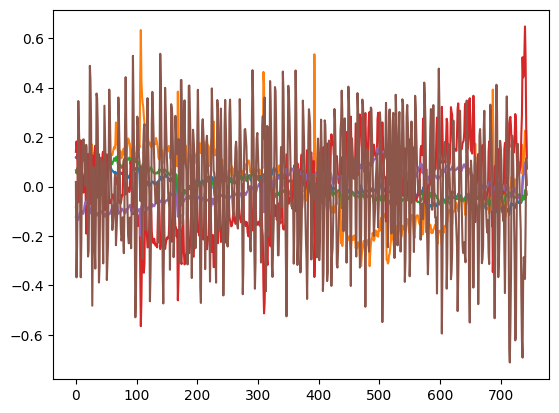

In [115]:
t=0 # first task
s=0 # first subject
sub = subs[s]
#list all possible combination of correct answer(target) and subject response 
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']

# examine regressors of no interest generated by micapipe
motion_reg = all_motion_reg[t][s]
# Specify the timing of fmri frames
frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

plt.plot(motion_reg);

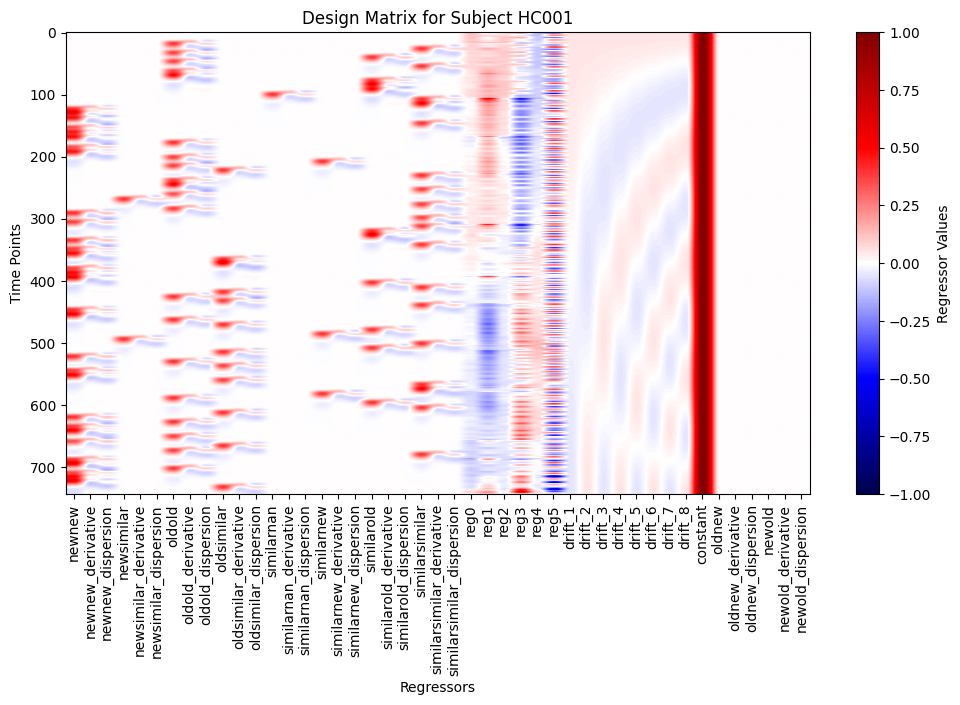

In [116]:
# create design matrix

# Load event files
events = all_events[t][s]
df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
# Recode events to have easy-to-read names
df = df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'})
# Combine response and condition to get all possible combinations
true_con = events['trial_type'] + events["subject response"].astype('str')
df['trial_type'] = true_con
print(df.to_string(max_rows=4))

design_matrix = make_first_level_design_matrix(frame_times,
                                              events=df,
                                              hrf_model='spm + derivative + dispersion',
                                              add_regs=motion_reg)

# in some cases, there are no trials of a certain type (eg. someone never pressed "new" to and "old" stimulus.
# in this case add extra columns to the design matrix with all 0s
# this will help us look at all trial types later
for condition in conditions:
    if condition not in design_matrix.columns:
        # Create columns for condition, its derivatives, and dispersion
        design_matrix[condition] = 0
        design_matrix[f'{condition}_derivative'] = 0
        design_matrix[f'{condition}_dispersion'] = 0    
        
# plot design matrix
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

In [117]:
# define contrasts of interest
# nibabel expects contrasts to be defined as a dictionary. Here, we first make a dictionary of basic contrasts for each column of our design matrix (1 for that column, 0 for all others)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
            for i, column in enumerate(design_matrix.columns)])

# now we define actual contrasts of interest for each trial type, without subtracting any other trial type (i.e. uncorrected)
contrasts = {
'patternseparation_uncorrected': (
    basic_contrasts['similarsimilar']
    + basic_contrasts['similarsimilar_derivative']
    + basic_contrasts['similarsimilar_dispersion']),
'patterncompletion_uncorrected': (
    basic_contrasts['oldsimilar']
    + basic_contrasts['oldsimilar_derivative']
    + basic_contrasts['oldsimilar_dispersion']),
'noveltydetection_uncorrected': (
    basic_contrasts['newnew']
    + basic_contrasts['newnew_derivative']
    + basic_contrasts['newnew_dispersion']),
# now we will subtract trials where the subject "failed" the trial type of interest
'patternseparation': (
    basic_contrasts['similarsimilar']
    - basic_contrasts['similarnew']
    + basic_contrasts['similarsimilar_derivative']
    - basic_contrasts['similarnew_derivative']
    + basic_contrasts['similarsimilar_dispersion']
    - basic_contrasts['similarnew_dispersion']),
'patterncompletion': (
    basic_contrasts['oldsimilar']
    - basic_contrasts['oldnew']
    + basic_contrasts['oldsimilar_derivative']
    - basic_contrasts['oldnew_derivative']
    + basic_contrasts['oldsimilar_dispersion']
    - basic_contrasts['oldnew_dispersion']),
'noveltydetection': (
    basic_contrasts['newnew']
    - 0.5*basic_contrasts['oldsimilar']
    - 0.5*basic_contrasts['oldnew']
    + basic_contrasts['newnew_derivative']
    - 0.5*basic_contrasts['oldsimilar_derivative']
    - 0.5*basic_contrasts['oldnew_derivative']
    + basic_contrasts['newnew_dispersion']
    - 0.5*basic_contrasts['oldsimilar_dispersion']
    - 0.5*basic_contrasts['oldnew_dispersion'])}

contrasts

{'patternseparation_uncorrected': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'patterncompletion_uncorrected': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'noveltydetection_uncorrected': array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'patternseparation': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 'pa

Now we'll fit the actual data to the design matrix and run our contrasts of interest!

In [118]:
h=0
l=0
        
# fit the design matrix to the data
labels_, estimates = run_glm(cdata_hipp[iV[l],h,:motion_reg.shape[0],t,s].T, design_matrix.values)

# run contrasts of interest
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    # Compute contrast-related statistics
    contrast = compute_contrast(labels_, estimates, contrast_val,
                                contrast_type='t')
    # We present the Z-transform of the t map
    z_score = contrast.z_score()

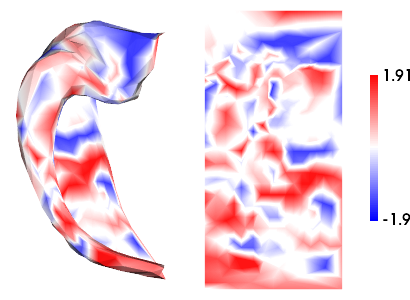

In [119]:
# plot hippocampal results (from the last iteration above. That is - noveltydetection for the right hemisphere)
hm.plotting.surfplot_canonical_foldunfold(z_score, den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

Now that we've run through a full example for one subject, we'll loop through all subjects and save the data:

In [120]:
#list all possible combination of correct answer(target) and subject response 
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']
nContrasts=6
contrasts_patternsep2 = np.ones((nV, len(hemis), len(subs), nContrasts))*np.nan # 6 different contrasts will be considered
contrasts_patternsep2_neo = np.ones((nP, len(hemis), len(subs), nContrasts)) * np.nan
t = 0 # first task

for s,sub in enumerate(subs): 
    
    # load in regressors of no interest generated by micapipe
    motion_reg = all_motion_reg[s][t]
    nTRs = motion_reg.shape[0]
    # Specify the timing of fmri frames
    frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###

    # Load event files
    events = all_events[s][t]
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
    # Recode events to have easy-to-read names
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    # Combine response and condition to get all possible combinations
    true_con = events['trial_type'] + events["subject response"].astype('str')
    df['trial_type'] = true_con

    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg)

    # in some cases, there are no trials of a certain type (eg. someone never pressed "new" to and "old" stimulus.
    # in this case add extra columns to the design matrix with all 0s
    # this will help us look at all trial types later
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0  

    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    # now we define actual contrasts of interest for each trial type, without subtracting any other trial type (i.e. uncorrected)
    contrasts = {
    'patternseparation_uncorrected': (
        basic_contrasts['similarsimilar']
        + basic_contrasts['similarsimilar_derivative']
        + basic_contrasts['similarsimilar_dispersion']),
    'patterncompletion_uncorrected': (
        basic_contrasts['oldsimilar']
        + basic_contrasts['oldsimilar_derivative']
        + basic_contrasts['oldsimilar_dispersion']),
    'noveltydetection_uncorrected': (
        basic_contrasts['newnew']
        + basic_contrasts['newnew_derivative']
        + basic_contrasts['newnew_dispersion']),
    # now we will subtract trials where the subject "failed" the trial type of interest
    'patternseparation': (
        basic_contrasts['similarsimilar']
        - basic_contrasts['similarnew']
        + basic_contrasts['similarsimilar_derivative']
        - basic_contrasts['similarnew_derivative']
        + basic_contrasts['similarsimilar_dispersion']
        - basic_contrasts['similarnew_dispersion']),
    'patterncompletion': (
        basic_contrasts['oldsimilar']
        - basic_contrasts['oldnew']
        + basic_contrasts['oldsimilar_derivative']
        - basic_contrasts['oldnew_derivative']
        + basic_contrasts['oldsimilar_dispersion']
        - basic_contrasts['oldnew_dispersion']),
    'noveltydetection': (
        basic_contrasts['newnew']
        - 0.5*basic_contrasts['oldsimilar']
        - 0.5*basic_contrasts['oldnew']
        + basic_contrasts['newnew_derivative']
        - 0.5*basic_contrasts['oldsimilar_derivative']
        - 0.5*basic_contrasts['oldnew_derivative']
        + basic_contrasts['newnew_dispersion']
        - 0.5*basic_contrasts['oldsimilar_dispersion']
        - 0.5*basic_contrasts['oldnew_dispersion'])}
    
    for h, hemi in enumerate(hemis):

        ### fit the design matrix to the data
        labels_, estimates = run_glm(cdata_hipp[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it
        labels_neo, estimates_neo = run_glm(neo_ts[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it

        ### run contrasts of interest
        for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
            contrasts_patternsep2[:, h, s, c] = contrast.z_score()
            contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
            contrasts_patternsep2_neo[:, h, s, c] = contrast.z_score()


## 1.2) Group-averaging and significance/consistency testing

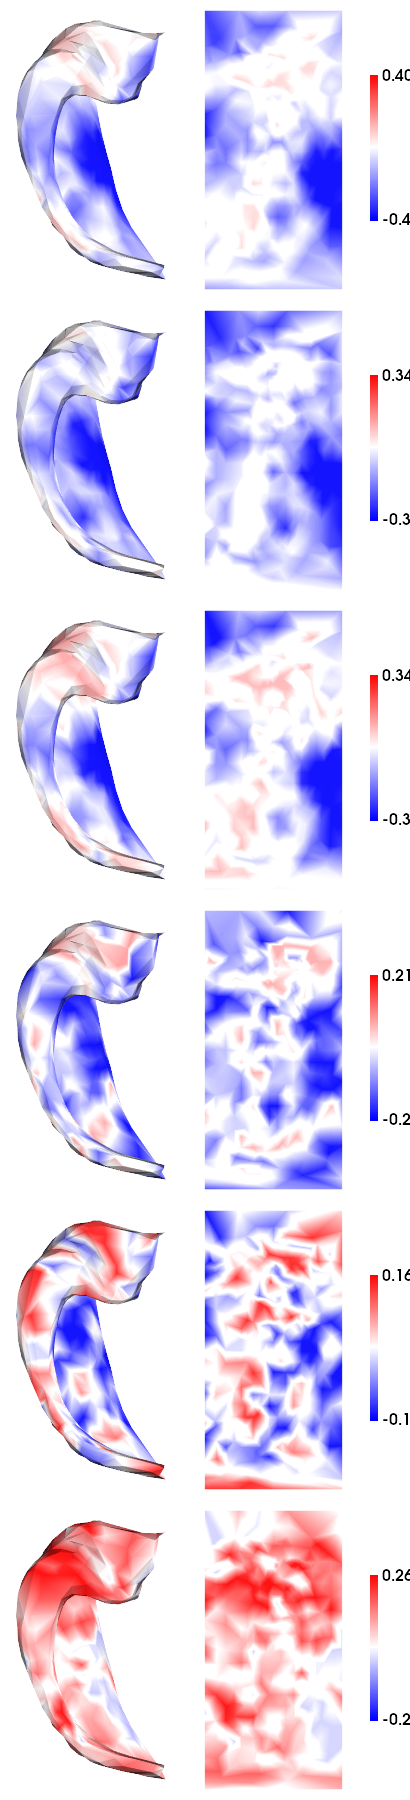

In [121]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_patternsep2,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

**significance testing**

We won't go into detail here, but this gives a basic idea of (uncorrected) significance values. Ideally, some cluster correction should be applied

In [122]:
contrasts_patternsep2.shape

(419, 2, 82, 6)

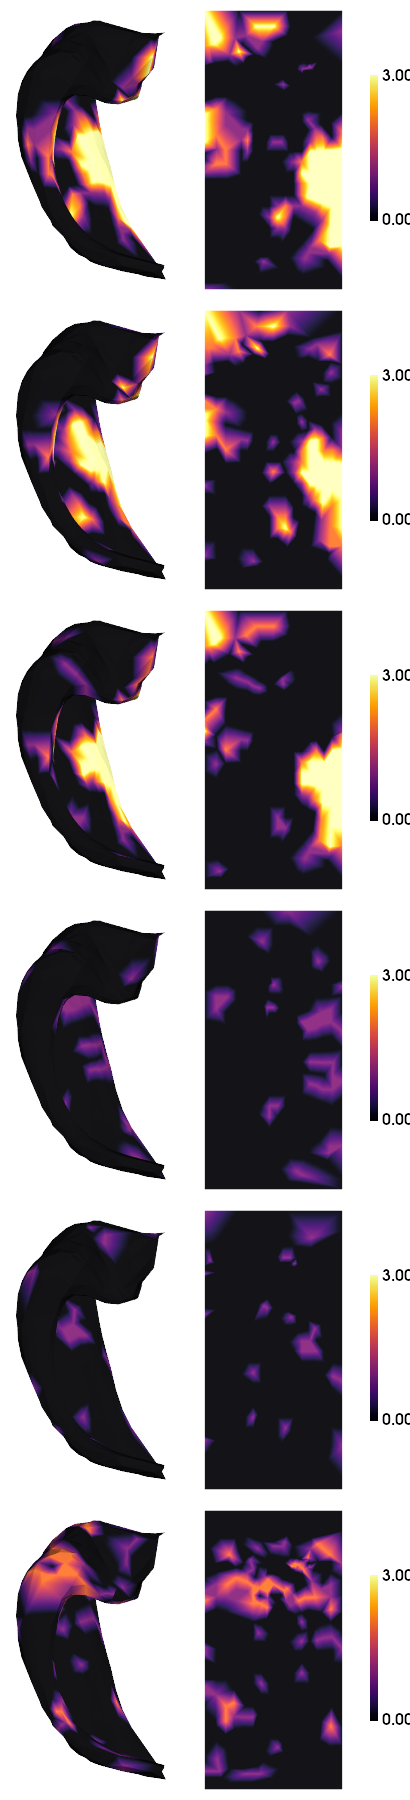

In [123]:
tstats = ttest_1samp(contrasts_patternsep2.reshape(nV,2*len(subs),nContrasts),0,axis=1)
tmap = np.zeros(tstats[1].shape)
tmap[tstats[1]<(0.05)] = 1
tmap[tstats[1]<(0.01)] = 2
tmap[tstats[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

**Additional consistency checks**

Rather than significance, we can also check consistency between subject results

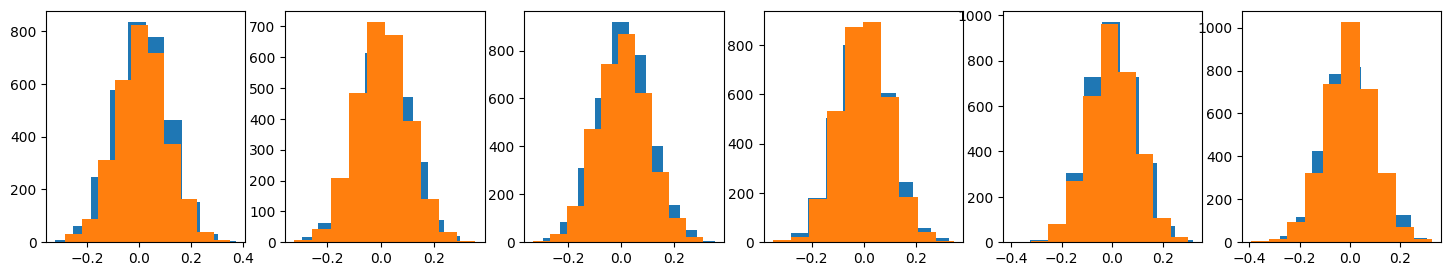

In [124]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(list(contrasts.keys())):
        cdat = contrasts_patternsep2[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        print(ttest_1samp(fcorr,0,nan_policy='omit'))
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

(0.0, 0.12343524111653331)

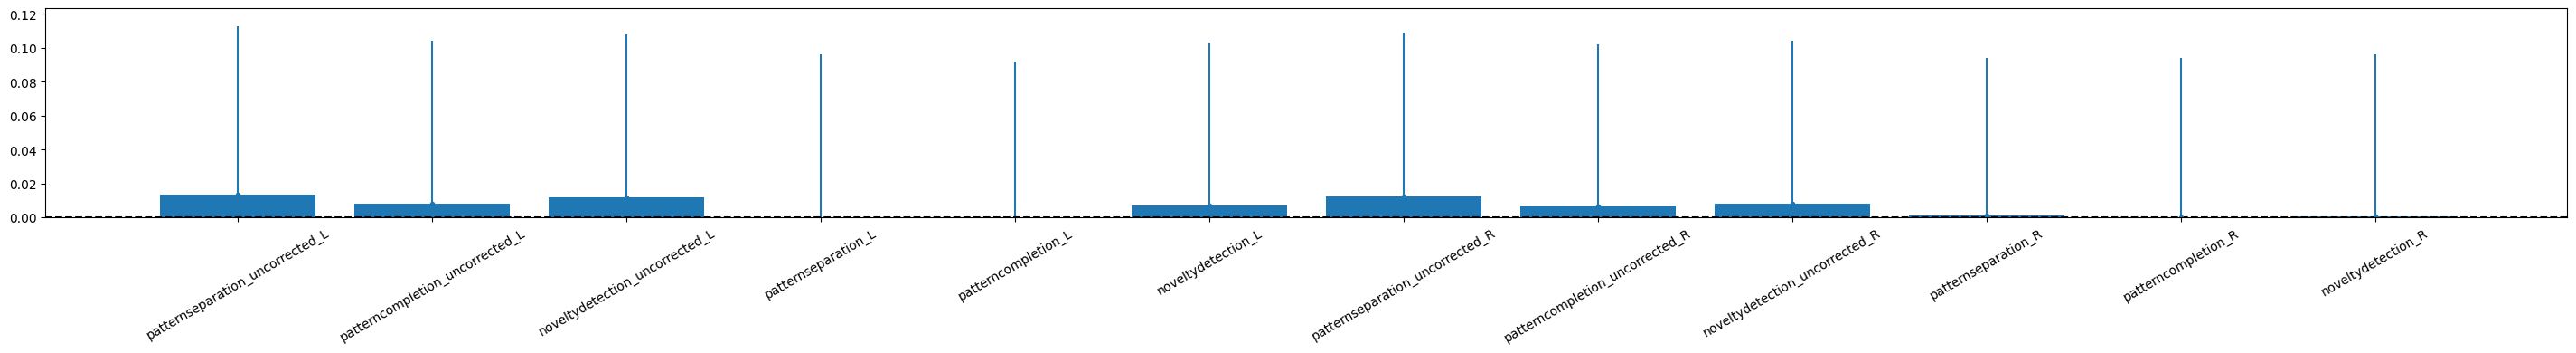

In [125]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
plt.gca().set_ylim(bottom=0)

In [126]:
#save the average maps
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for c,cname in enumerate(list(contrasts.keys())):
            cdat = np.nanmean(contrasts_patternsep2[iV[l],h,:,c],axis=1).flatten().astype(np.float32) 
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-MST2_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}_contrast-{cname}.shape.gii')

## 1.3) Consider neocortical results

All the same as above, but with neocortical surfaces (and stacking left+right hemispheres)

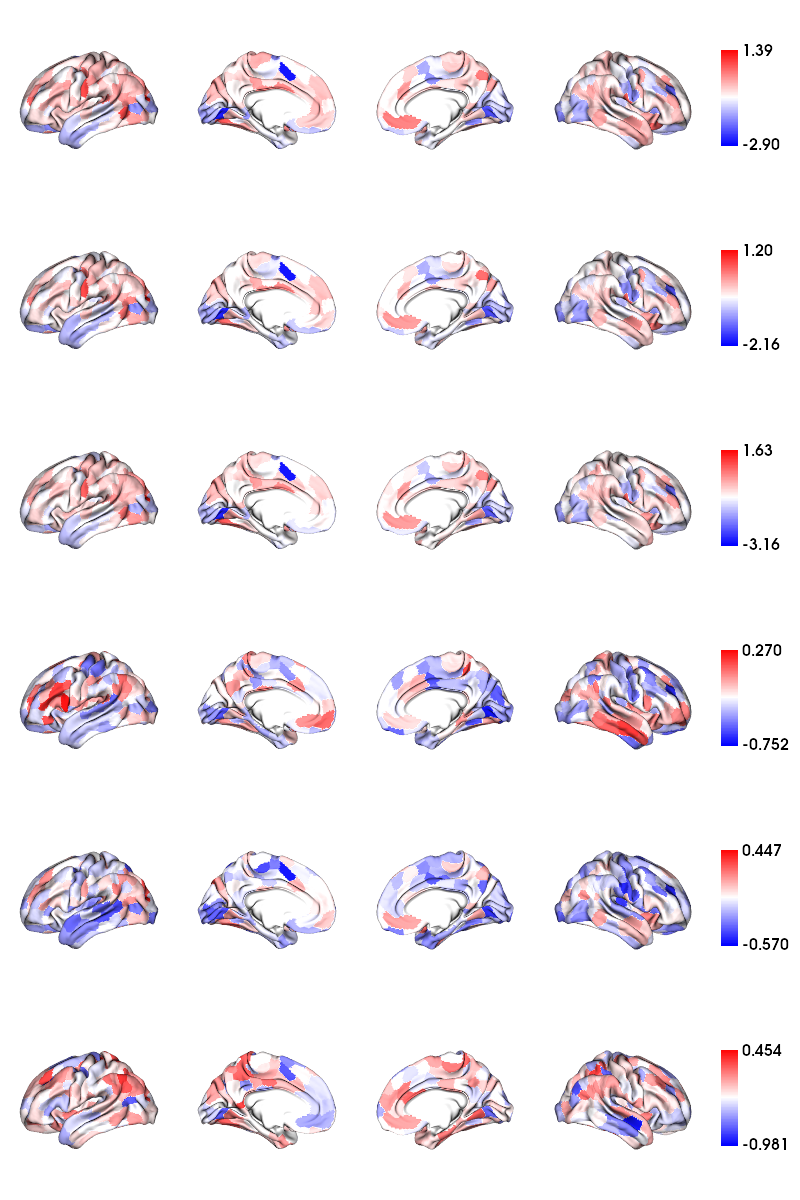

In [127]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, nContrasts])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(list(contrasts.keys())): 
            mc[parc==(i+1+(h*nP)),c] = np.nanmean(contrasts_patternsep2_neo,axis=2)[i,h,c]
            
plot_hemispheres(c69_inf_lh, c69_inf_rh,array_name=np.hsplit(mc,len(list(contrasts.keys()))), 
                 size=(800,200*len(list(contrasts.keys()))), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

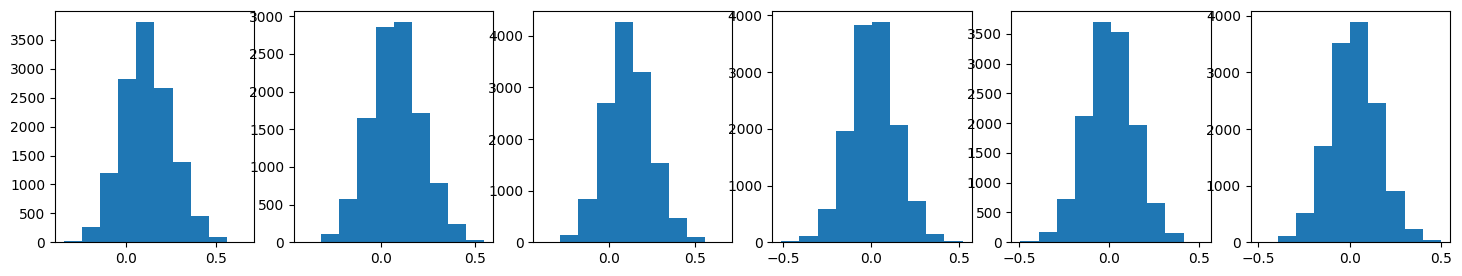

In [128]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*len(list(contrasts.keys())),3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_patternsep2_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    print(ttest_1samp(fcorr,0,nan_policy='omit'))
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

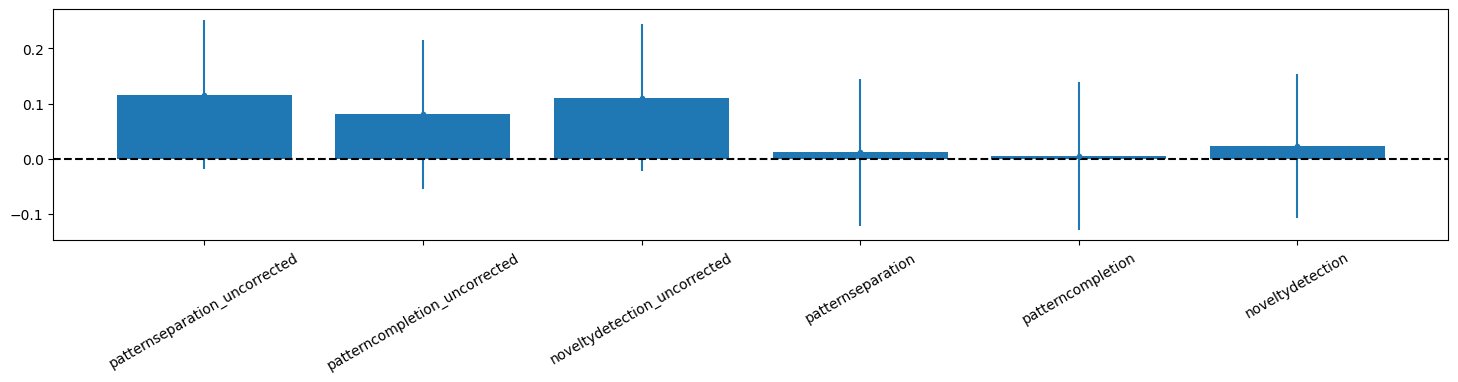

In [129]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*nContrasts,3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 1.4) Compare to previously mapped features

In HippoMaps, we present a high-order space of all features correlated with a continuous anterior-posterior axis by a discrete proximal-distal subfields. Here, we reload that space to find where the present maps fall, and which other mapped features they are most similar to

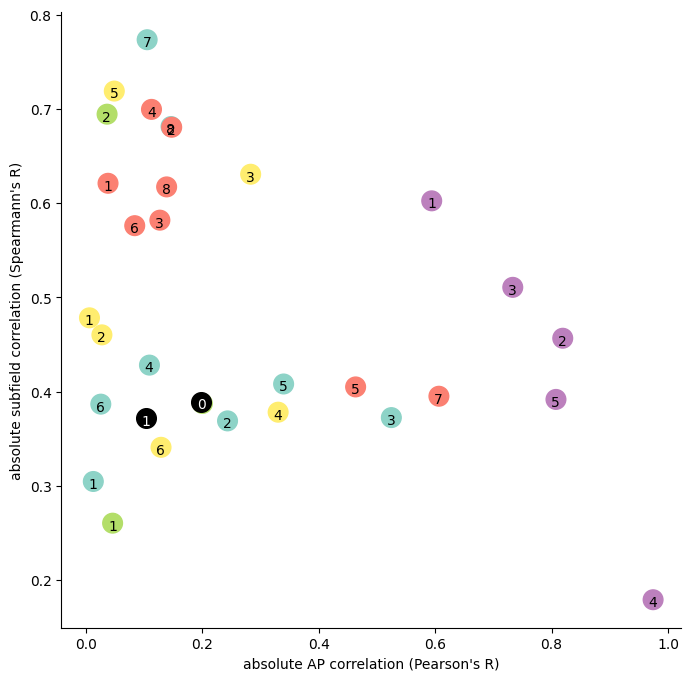

In [130]:
# here we look only at the pattern separation and novelty conditions
feats_to_examine = [0,2]
cdata = np.nanmean(contrasts_patternsep2,axis=(1,2))[:,feats_to_examine]
context2D, ax = hm.stats.contextualize2D(cdata, nperm=10) # Note that for the sake of speed nperm is set low, but ideally it should be 10000

## 2) Episodic Retrieval

## 2.1) GLM fit
This section is very similar to the above, but with different input data, conditions, and contrasts. We also don't walk through one subject, but rather run all subjects together

In [131]:
nContrasts = 2
contrasts_epiretrieve = np.ones((nV, len(hemis), len(subs), nContrasts))*np.nan # 2 different contrasts will be considered
contrasts_epiretrieve_neo = np.ones((nP, len(hemis), len(subs), nContrasts)) * np.nan

conditions = ['remembered', 'forgotten']
t = 2
for s,sub in enumerate(subs):
    # Specify the timing of fmri frames from one example
    motion_reg = all_motion_reg[s][t]
    nTRs = motion_reg.shape[0]
    frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load event files
    events = all_events[s][t]
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time','subject_response','prime','target']]
    # Recode events to have easy-to-read names
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    df['trial_type']=None
    df['trial_type'] = df.apply(lambda row: 'remembered' if row['target'] == row['subject_response'] else 'forgotten', axis=1)

    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg
                                                  )
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
    'retrieval_uncorrected': (
        basic_contrasts['remembered']
        + basic_contrasts['remembered_derivative']
        + basic_contrasts['remembered_dispersion']),
    'retrieval_corrected': (
        basic_contrasts['remembered']
        - basic_contrasts['forgotten']
        + basic_contrasts['remembered_derivative']
        - basic_contrasts['forgotten_derivative']
        + basic_contrasts['remembered_dispersion']
        + basic_contrasts['forgotten_dispersion'])}
    
    for h, hemi in enumerate(hemis):

        ### fit the design matrix to the data
        labels_, estimates = run_glm(cdata_hipp[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it
        labels_neo, estimates_neo = run_glm(neo_ts[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it

        ### run contrasts of interest
        for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
            contrasts_epiretrieve[:, h, s, c] = contrast.z_score()
            contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
            contrasts_epiretrieve_neo[:, h, s, c] = contrast.z_score()

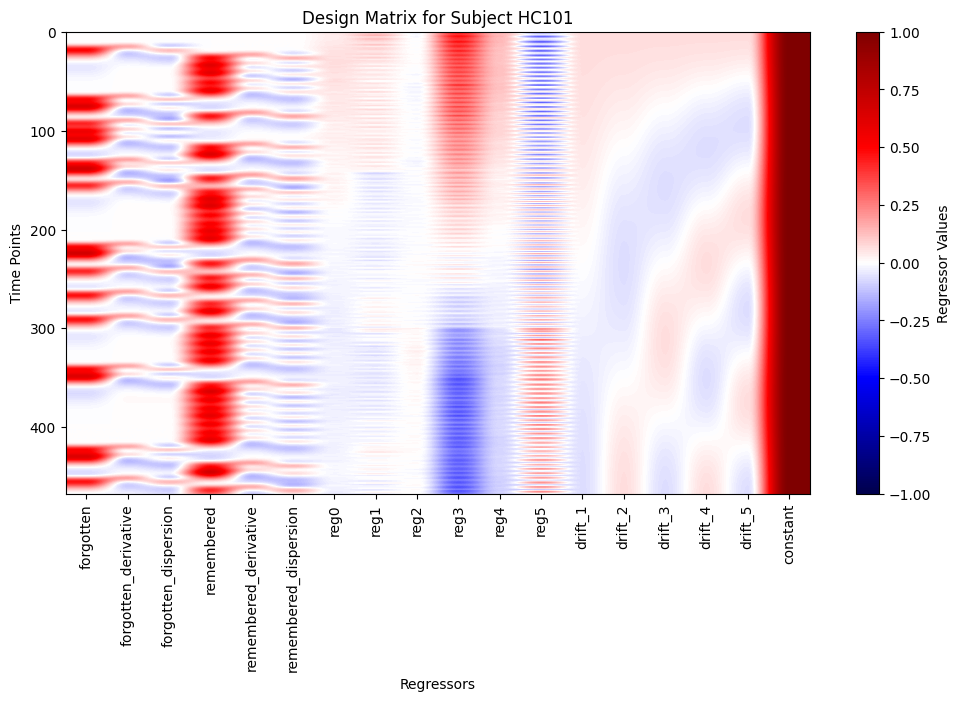

In [132]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

## 2.2) Group-averaging and significance/consistency testing

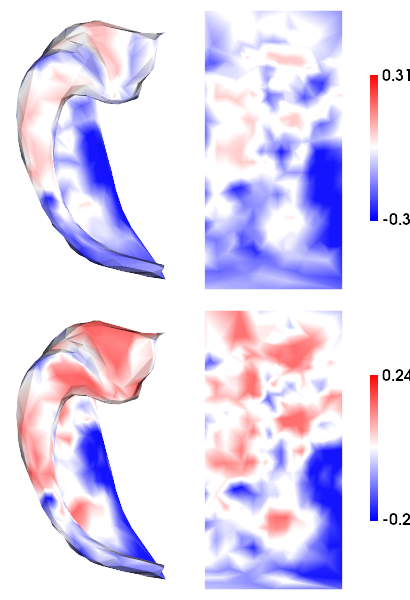

In [133]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiretrieve,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

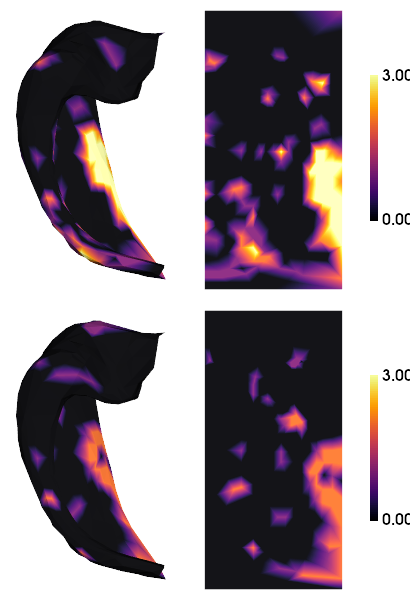

In [134]:
t = ttest_1samp(contrasts_epiretrieve.reshape((nV,2*len(subs),nContrasts)),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [135]:
#save the average maps
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for c,contrastname_epiretrieve in enumerate(list(contrasts.keys())):
            cdat = np.nanmean(contrasts_epiretrieve[iV[l],h,:,c],axis=1).flatten().astype(np.float32) 
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiretrieve_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiretrieve}.shape.gii')

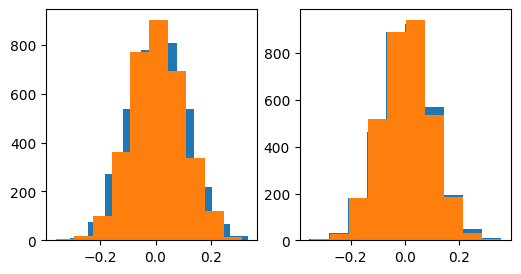

In [136]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(list(contrasts.keys())):
        cdat = contrasts_epiretrieve[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        print(ttest_1samp(fcorr,0,nan_policy='omit'))
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

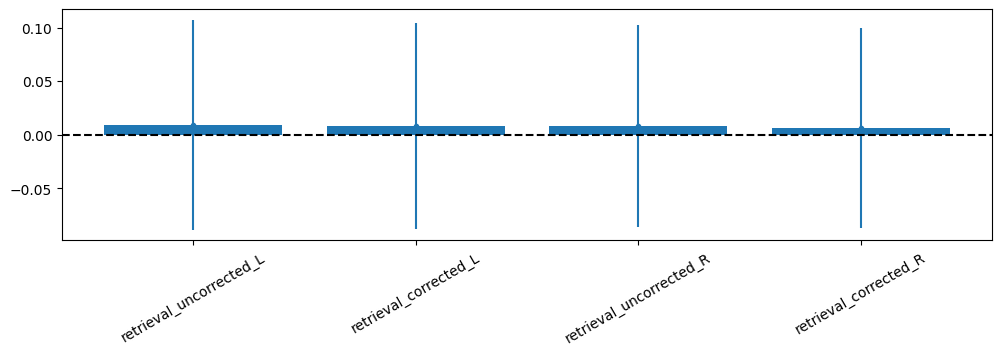

In [137]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 2.3) Consider the neocortex

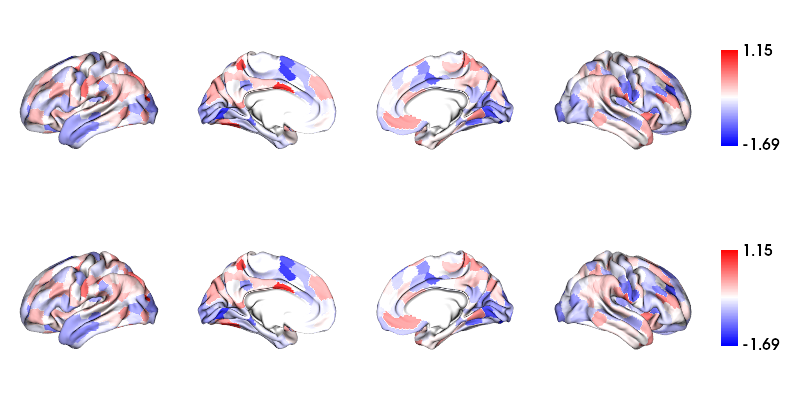

In [138]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, nContrasts])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(list(contrasts.keys())): 
            mc[parc==(i+1+(h*nP))] = np.nanmean(contrasts_epiretrieve_neo,axis=2)[i,h,c]
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,len(list(contrasts.keys()))), 
                 size=(800,200*len(list(contrasts.keys()))), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

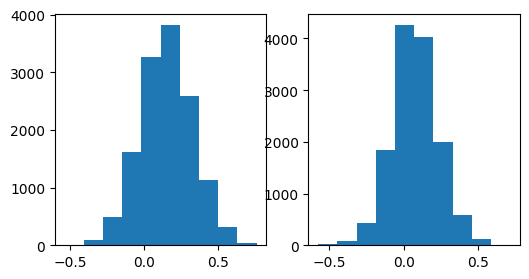

In [139]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_epiretrieve_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

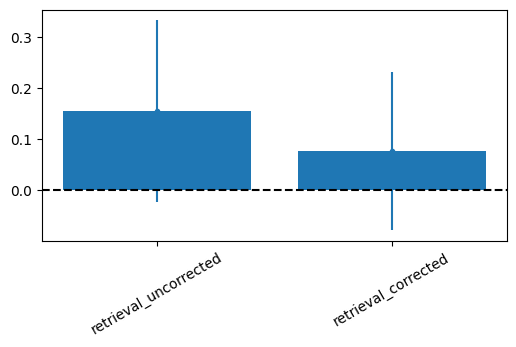

In [140]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(list(contrasts.keys())),3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 3) Episodic encoding -subsequent memory 

## 3.1) GLM fit
Again, this section is very similar to the above, but with different input data, conditions, and contrasts. We also don't walk through one subject, but rather run all subjects together

In [141]:
nContrasts = 2
contrasts_epiencode = np.ones((nV, len(hemis), len(subs), nContrasts))*np.nan # 2 different contrasts will be considered
contrasts_epiencode_neo = np.ones((nP, len(hemis), len(subs), nContrasts)) * np.nan

conditions = ['correct', 'incorrect']
current_task='epiencode'
t = 1 # second task

for s,sub in enumerate(subs):
    # Specify the timing of fmri frames from one example
    motion_reg = all_motion_reg[s][t]
    nTRs = motion_reg.shape[0]
    frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # This is slightly more complicated now since we need to look up which stimuli were actually subsequently remmebered by matching their IDs
    
    # Load encoding file
    df_encode = all_events[s][t]
    df_encode= df_encode[['event_1_onset','event_1_duration','event_2_onset', 'stim_duration','stim_1','stim_2']]
    # Recode events to have easy-to-read names
    df_encode.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'stim_duration': 'duration'}, inplace=True)
    # Load retrieval file
    df_retrieve = all_events[s][2]
    df_retrieve=df_retrieve[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'event_3_onset','subject_response']]
    # Recode events to have easy-to-read names
    df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress'}, inplace=True)
    df_retrieve['trial_type']=None
    df_retrieve['trial_type'] = df_retrieve.apply(lambda row: 'correct' if row['target'] == row['subject_response'] else 'incorrect', axis=1)

    new_df = pd.DataFrame(columns=['onset','duration','prime','target','trial_type'])
    # Dictionary to keep track of matched rows in df_retrieve
    matched_rows_dict = {}

    # Iterate through rows in encoding data
    i=0
    for index, row_encode in df_encode.iterrows():
        stim_1 = row_encode['stim_1']
        stim_2 = row_encode['stim_2']

        # Check if this pair has already been matched
        if (stim_1, stim_2) not in matched_rows_dict:
            # Match rows in retrieval data based on stim_1 and stim_2
            match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

            # If there is exactly one match, append the data to the design matrix
            if len(match_rows) == 1:
                matched_row = match_rows.iloc[0]
                new_df.loc[i] = [row_encode['onset'],
                                 row_encode['duration'],
                                 matched_row['prime'],
                                 matched_row['target'],
                                 matched_row['trial_type']]
                i+=1

                # Update the matched_rows_dict to mark this pair as matched
                matched_rows_dict[(stim_1, stim_2)] = True
            else:
                # If there is no match or multiple matches, mark this pair as unmatched
                matched_rows_dict[(stim_1, stim_2)] = False

    design_matrix = make_first_level_design_matrix(frame_times,
                                      events=new_df,
                                      hrf_model='spm + derivative + dispersion',
                                      add_regs=motion_reg)
    for condition in conditions:
        if condition not in design_matrix.columns:
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
                    'subsequent_memory_uncorrected': (
                        basic_contrasts['correct']
                        + basic_contrasts['correct_derivative']
                        + basic_contrasts['correct_dispersion']),
                    'subsequent_memory_corrected': (
                        basic_contrasts['correct']
                        - basic_contrasts['incorrect']
                        + basic_contrasts['correct_derivative']
                        - basic_contrasts['incorrect_derivative']
                        + basic_contrasts['correct_dispersion']
                        - basic_contrasts['incorrect_dispersion'])}

    for h, hemi in enumerate(hemis):

        ### fit the design matrix to the data
        labels_, estimates = run_glm(cdata_hipp[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it
        labels_neo, estimates_neo = run_glm(neo_ts[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it

        ### run contrasts of interest
        for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
            contrasts_epiencode[:, h, s, c] = contrast.z_score()
            contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
            contrasts_epiencode_neo[:, h, s, c] = contrast.z_score()

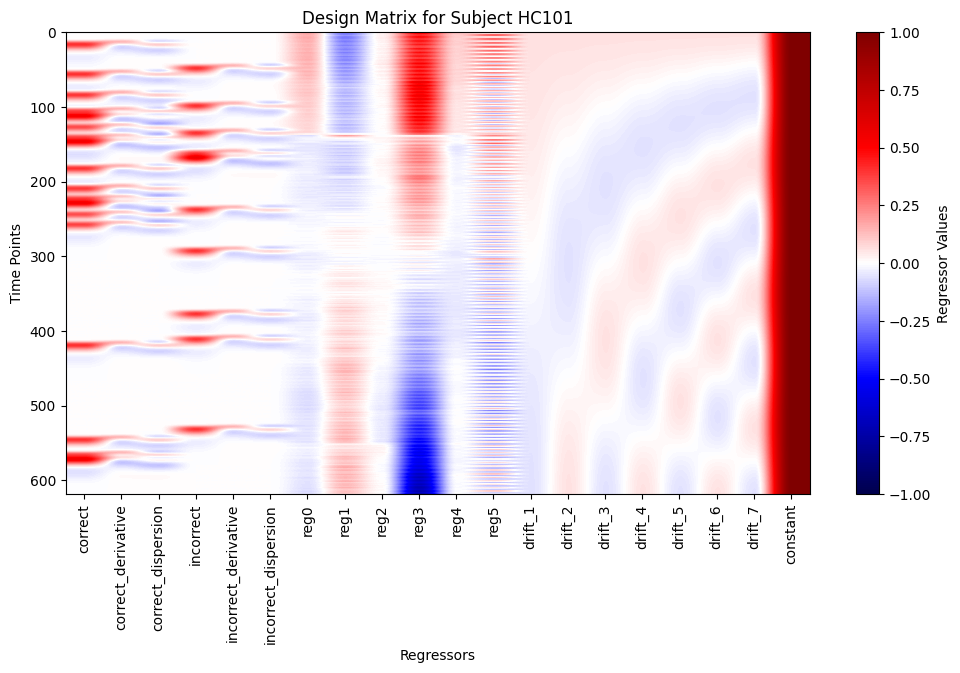

In [142]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

## 3.2) Group-averaging and significance/consistency testing

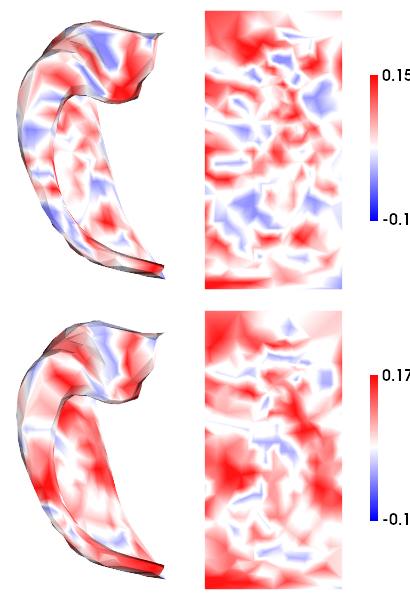

In [143]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiencode,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

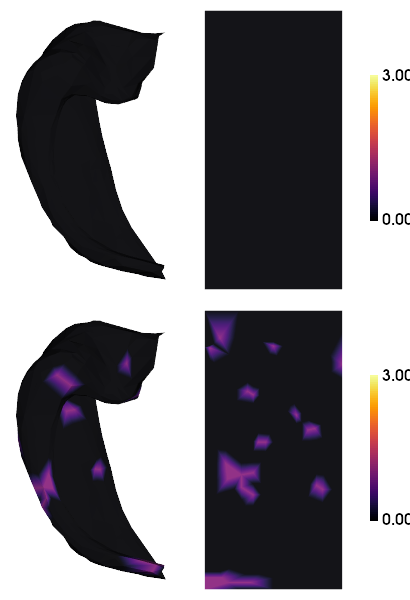

In [144]:
t = ttest_1samp(contrasts_epiencode.reshape((nV,2*len(subs),nContrasts)),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [145]:
#save the average maps
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for c,contrastname_epiencode in enumerate(list(contrasts.keys())):
            cdat = np.nanmean(contrasts_epiencode[iV[l],h,:,c],axis=1).flatten().astype(np.float32) 
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiencode_average-{len(subs)}-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiencode}.shape.gii')

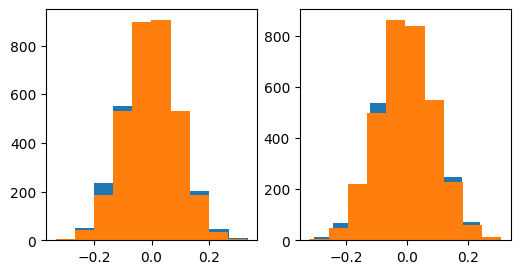

In [146]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(list(contrasts.keys())):
        cdat = contrasts_epiencode[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

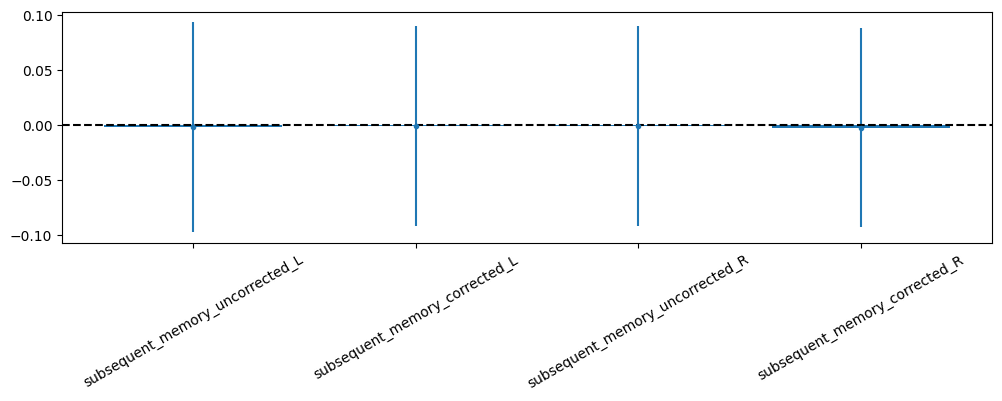

In [147]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 3.3) Consider the neocortex

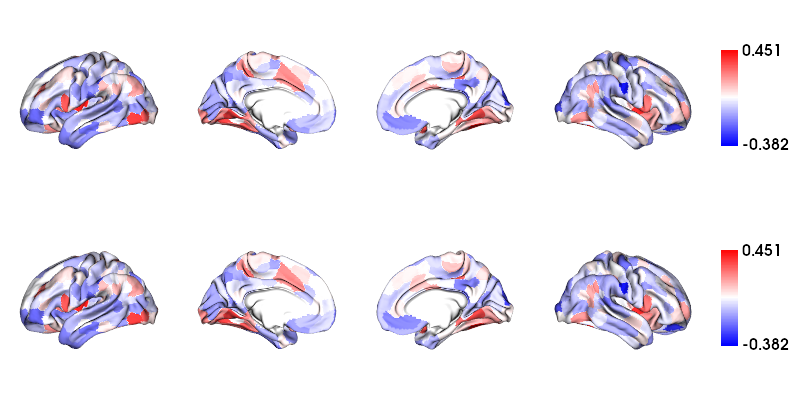

In [148]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, nContrasts])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(list(contrasts.keys())): 
            mc[parc==(i+1+(h*nP))] = np.nanmean(contrasts_epiencode_neo,axis=2)[i,h,c]
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,len(list(contrasts.keys()))), 
                 size=(800,200*len(list(contrasts.keys()))), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

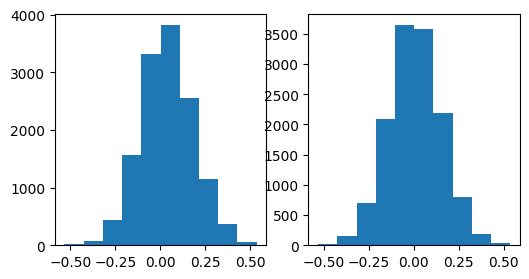

In [149]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_epiencode_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

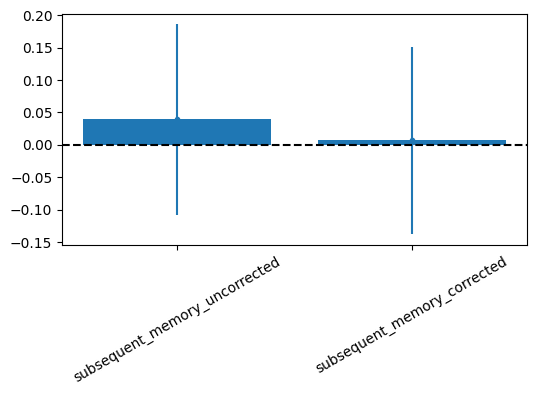

In [150]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*nContrasts,3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

In [151]:
end_time = time.time()
duration = end_time - start_time
print(f"Total duration: {duration:.2f} seconds")
duration

2260.946700811386